# Statistical Computing with Python Assignment 📊  

### Task: Scraping Historical Population Data from Worldometers Website 🌍  

### Group Members:  
- **Dagim Alemu Taye** | GSR-9713-17  
- **Yishak Abreham**   | GSR-5427-17  



# Install Required Libraries 🚀  

Run the following command to install the necessary packages:  

```bash
pip install beautifulsoup4 requests pandas tqdm


In [26]:
pip install beautifulsoup4 requests pandas tqdm #lets install beatiful soup 🍲

# Import Descriptions  

- `import requests` – Sends HTTP requests to fetch web pages. 🌐  
- `from requests.adapters import HTTPAdapter` – Manages request sessions and connections. 🔄  
- `from urllib3.util.retry import Retry` – Automatically retries failed requests. 🔁  
- `from bs4 import BeautifulSoup` – Parses and extracts data from HTML. 🏗️  
- `import pandas as pd` – Stores and processes scraped data in tables. 📊  
- `from tqdm import tqdm` – Displays a progress bar for loops. ⏳  
- `import time` – Adds delays to prevent getting blocked. ⏱️  


In [127]:
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry 
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
import time

# Configuration Constants ⚙️  

- `BASE_URL` – The target website for population data. 🌍  
- `REQUEST_TIMEOUT` – Maximum time (in seconds) to wait for a response. ⏳  
- `RETRY_STRATEGY` – Defines retry rules for failed requests. 🔁  
  - `total=3` – Maximum retry attempts.  
  - `backoff_factor=1` – Delay increases between retries.  
  - `status_forcelist=[429, 500, 502, 503, 504]` – Retries only for these HTTP errors.  
- `DELAY_BETWEEN_REQUESTS` – Pause (in seconds) between requests to avoid overloading the server. ⏱️  


In [ ]:
# Configuration constants
BASE_URL = "https://www.worldometers.info/world-population/population-by-country/"
REQUEST_TIMEOUT = 10
RETRY_STRATEGY = Retry(
    total=3,
    backoff_factor=1,
    status_forcelist=[429, 500, 502, 503, 504]
)
DELAY_BETWEEN_REQUESTS = 1  # Seconds to be polite to the server

# Setup Session 🔄  

In [ ]:


def setup_session():
    """Create and configure a requests session with retry capabilities."""
    session = requests.Session()
    adapter = HTTPAdapter(max_retries=RETRY_STRATEGY)
    session.mount("https://", adapter)
    session.mount("http://", adapter)
    return session

# Get Country Links 🌍🔗  

### Function Explanation:  
- **Fetches the country list** from the main population data page using a configured session. 🌐  
- **Handles request errors** gracefully by catching exceptions and displaying an error message. ⚠️  
- **Parses the page** to find the table containing country names and population data links using BeautifulSoup. 🏗️  
- **Checks if the country table exists** on the page and returns an empty dictionary if not found. 🚫  
- **Extracts country names and links** to each country's population data page, storing them in a dictionary. 📚  


In [ ]:
def get_country_links(session):
    """Retrieve country names and their population data URLs."""
    try:
        response = session.get(BASE_URL, timeout=REQUEST_TIMEOUT)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching country list: {e}")
        return {}

    soup = BeautifulSoup(response.text, "html.parser")
    table = soup.find("table", {"id": "example2"})
    
    if not table:
        print("Country table not found on the page")
        return {}

    country_links = {}
    for link in table.find_all("a"):
        country_name = link.text.strip()
        country_path = link.get("href")
        if country_path:
            country_links[country_name] = f"https://www.worldometers.info{country_path}"
    
    return country_links

# Scrape Country Data 🌍📊  

### Function Explanation:  
- **Fetches population data** for a specific country by making a request to its dedicated page. 🌐  
- **Handles request errors** by catching exceptions and printing a message if an error occurs. ⚠️  
- **Parses the page** with BeautifulSoup to find the relevant table that holds the country's population data. 🏗️  
- **Checks if the data table exists** on the page and returns `None` if not found. 🚫  
- **Extracts data from the table rows**, skipping the header, and stores the information like year, population, yearly change, etc., in a list. 📊  
- **Returns the extracted data** for the country, including its name and key population metrics. 📚  


In [149]:
def scrape_country_data(session, country_name, country_url):
    
    try:
        response = session.get(country_url, timeout=REQUEST_TIMEOUT)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for {country_name}: {e}")
        return None

    soup = BeautifulSoup(response.text, "html.parser")
    table = soup.find("table", {"class": "table table-striped table-bordered table-hover table-condensed table-list"})
    
    if not table:
        print(f"Data table not found for {country_name}")
        return None

    data = []
    for row in table.find_all("tr")[1:]:  # Skip header
        cols = [col.text.strip() for col in row.find_all("td")]
        if len(cols) < 13:
            continue

        data.append([
            country_name, cols[0], cols[1], cols[2], cols[3], cols[4], cols[5], cols[6], cols[7], cols[8], cols[9], cols[10], cols[11], cols[12]     
            
        ])
    
    return data

# Main Scraping Workflow 🧑‍💻🌍  

### Function Explanation:  
- **Sets up the session** for web scraping using `setup_session()`. 🔄  
- **Fetches the country links** by calling `get_country_links()` and checks if any links were found. 🚀  
- **Iterates over each country** and its URL, scraping population data for each country using `scrape_country_data()`. 📊  
- **Handles rate-limiting** by adding a delay between requests to be polite to the server. ⏱️  
- **Collects and stores data** in a `pandas` DataFrame, which includes columns like year, population, yearly change, and more. 📚  
- **Saves the collected data** to a CSV file (`world_population_data.csv`) for future use. 💾  
- **Displays a success message** or an error message depending on whether data was collected. ✅❌  

### Final Output:  
- The data is saved to a CSV file with population statistics for each country. 📊


In [146]:
def main():
    session = setup_session()
    country_links = get_country_links(session)
    
    if not country_links:
        print("No Such Country Skipped 🙊")
        return

    all_data = []
    print(f"Found {len(country_links)} countries. Starting data collection...")

    for country, url in tqdm(country_links.items(), desc="Beatiful soup 🍲 is Scraping Countries 🚶‍♂️‍➡️🚶🏿‍♂️‍➡️"):
        country_data = scrape_country_data(session, country, url)
        if country_data:
            all_data.extend(country_data)
        time.sleep(DELAY_BETWEEN_REQUESTS)

    if all_data:
        df = pd.DataFrame(all_data, columns=[
            "Country ", "Year", "Population", "Yearly Change", "Net Change", "Migrants (net)", "Median Age", "Urban Population %","Density (P/Km²)",
            "Urban Pop% ","Urban population","Country's Share of World Pop","World Population","Global Rank"
        ])
        df.to_csv("world_population_data.csv", index=False)
        print("🫡Data successfully saved as a csv file")
    else:
        print("⛔Nothing here to see No data.")

if __name__ == "__main__":
    main()

Found 234 countries. Starting data collection...


Beatiful soup 🍲 is Scraping Countries 🫣: 100%|██████████| 234/234 [05:18<00:00,  1.36s/it]

Data successfully saved to world_population_data.csv


# Loading and Displaying the Data 📥📊

### Functionality Overview:
- **Load CSV File:**  
  The `pd.read_csv()` function is used to load the `world_population_data.csv` file into a pandas DataFrame (`df`). This CSV file contains historical population data.

- **Display First 20 Rows:**  
  The `df.head()` function displays the first 5 rows of the dataset, giving a quick preview of the data structure and content. This helps ensure that the data was loaded correctly and provides an initial glimpse of the columns and values. 🧐  


In [137]:
# Load the CSV file
df = pd.read_csv('world_population_data.csv')

# Display the first 5 rows
print(df.head(20))

   Country  Year     Population Yearly Change  Net Change Density (P/Km²)  \
0    India  2025  1,463,865,525        0.89 %  12,929,734        -495,753   
1    India  2024  1,450,935,791        0.89 %  12,866,195        -630,830   
2    India  2023  1,438,069,596        0.89 %  12,646,384        -979,179   
3    India  2022  1,425,423,212        0.79 %  11,219,316      -1,353,478   
4    India  2020  1,402,617,695        0.98 %  13,587,383         -73,806   
5    India  2015  1,328,024,498        1.32 %  16,908,587        -655,085   
6    India  2010  1,243,481,564        1.49 %  17,761,048         -50,905   
7    India  2005  1,154,676,322        1.77 %  19,350,718        -929,454   
8    India  2000  1,057,922,733        1.96 %  19,524,338        -143,960   
9    India  1995    960,301,044        2.11 %  19,065,765         -57,297   
10   India  1990    864,972,221        2.28 %  18,464,886         125,514   
11   India  1985    772,647,793        2.37 %  17,058,754         -89,991   

# Install Required Libraries 🚀  

Run the following command to install the necessary packages:  

```bash
pip install pandas matplotlib seaborn


In [35]:
pip install pandas matplotlib seaborn

# Data Analysis and Visualization 🧑‍💻📊

### Functionality Overview:
- **File Loading & Data Cleaning:**  
  The CSV file (`world_population_data.csv`) is loaded into a pandas DataFrame (`df`). The 'Net Change' column is cleaned by removing the '+' and ',' characters and converting the values to `float`. The 'Year' column is converted to datetime format and extracted as the year.

- **Cumulative Net Change Calculation:**  
  The data is grouped by 'Country' and the cumulative sum of 'Net Change' is calculated for each country. The top 10 countries with the highest cumulative population change are selected for visualization.

- **Visualization:**  
  The script generates two plots:
  1. **Top 10 Countries by Yearly Population Net Change:** A line plot showing the yearly population net change for the top 10 countries.
  2. **Total Cumulative Population Change:** A horizontal bar chart representing the total cumulative net change in population for the top 10 countries.

### Libraries Used:  
- `pandas` – Data manipulation and processing. 📊  
- `matplotlib` – Visualization of data using line and bar charts. 📈  
- `seaborn` – Styling and enhancing the plots. 🎨  

### Insights:  
- **Yearly Population Net Change:** This plot displays the population changes for the top 10 countries, showcasing their trends over time.
- **Total Cumulative Population Change:** This bar chart illustrates which countries have seen the highest cumulative net population changes from 1950 to the present. 🌍  


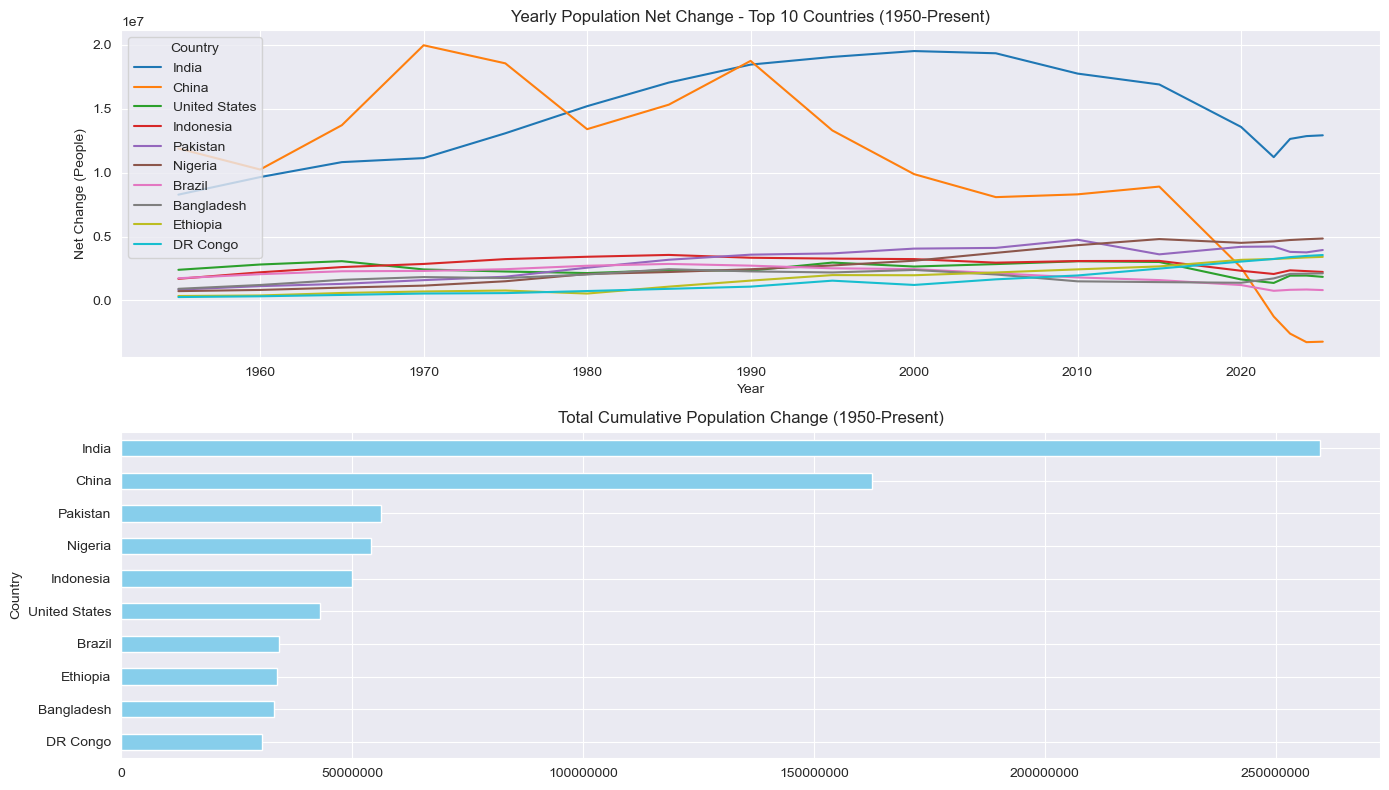

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Check if file exists
filename = "world_population_data.csv" 


# Load the data
df = pd.read_csv(filename)

# Data cleaning
df['Net Change'] = df['Net Change'].str.replace('[+,]', '', regex=True).astype(float)
df['Year'] = pd.to_datetime(df['Year'], format='%Y').dt.year

# Calculate cumulative net change
cumulative_change = df.groupby('Country')['Net Change'].sum().sort_values(ascending=False).head(10)

# Visualization
plt.figure(figsize=(14, 8))
sns.set_style("darkgrid")

# Top 10 countries plots
plt.subplot(2, 1, 1)
sns.lineplot(data=df[df['Country'].isin(cumulative_change.index)], 
             x='Year', y='Net Change', hue='Country',
             estimator=None, palette='tab10')
plt.title("Yearly Population Net Change - Top 10 Countries (1950-Present)")
plt.ylabel("Net Change (People)")

# change plot
plt.subplot(2, 1, 2)
cumulative_change.plot(kind='barh', color='skyblue')
plt.title("Total Cumulative Population Change (1950-Present)")
plt.xlabel("Total Net Change (Millions)").set_visible(False)
plt.gca().invert_yaxis()
plt.ticklabel_format(style='plain', axis='x')

plt.tight_layout()
plt.show()